# Project 1

[This dataset](https://raw.githubusercontent.com/cmparlettpelleriti/CPSC392ParlettPelleriti/master/Data/Proj1.csv) is adapted from the World Health Organization on Strokes (it's based on real data but is NOT REAL). Use this dataset to answer the following questions and perform the following tasks. Feel free to add extra cells as needed, but follow the structure listed here and clearly identify where each question is answered. Please remove any superflous code.

## Data Information

- `reg_to_vote`: 0 if no, 1 if yes.
- `age`: age of the patient in years.
- `hypertension`: 0 if the patient doesn't have hypertension, 1 if the patient has hypertension.
- `heart_disease`: 0 if the patient doesn't have any heart diseases, 1 if the patient has a heart disease.
- `ever_married`: 0 if no, 1 if yes.
- `Residence_type`: 0 for Rural, 1 for Urban.
- `avg_glucose_level`: average glucose level in blood.
- `bmi`: body mass index.
- `smoking_status_smokes`, `smoking_status_formerly`: Whether or not the person smokes, or formerly smoked. If a person has 0's for both these columns, they never smoked.
- `stroke`: 1 if the patient had a stroke or 0 if not.
- `dog_owner`: 0 if no, 1 if yes.
- `er_visits`: number of recorded Emergency Room visits in lifetime.
- `raccoons_to_fight`: number of racoons the patient belives they could fight off at once.
- `fast_food_budget_month`: amount (in US dollars) spent on fast food per month.


## Part I: Logistic Regression
Build a logistic regression model to predict whether or not someone had a `stroke` based on **all** the other variables in the dataset.

1. Count the missing data per column, and remove rows with missing data (if any).
2. Use 10 fold cross validation for your model validation. Z-score your continuous variables only. Store both the train and test accuracies to check for overfitting. **Is the model overfit? How can you tell?**
3. After completing steps 1-2, fit another logistic regression model on ALL of the data (no model validation; but do z score) using the same predictors as before, and put the coefficients into a dataframe called `coef`.
4. print out a confusion matrix for the model you made in part 3. **What does this confusion matrix tell you about your model? How can you tell?**

## Part II: Data Exploration
The WHO has asked the following five questions, create **at least 1 ggplot graph per question** (using the above data + model when needed) to help answer each question, and **explicitly answer the question in a Markdown cell** below your graph. You may use other calculations to help support your answer but MUST pair it with a graph. Write your answer as if you were explaining it to a non-data scientist. You will be graded on the effectiveness and clarity of your graph, as well as the completeness, clarity, and correctness of your responses and justifications.

1. In this specific data set, do dog-owners over 50 have a higher average probability of stoke than non-dog owners who currently smoke? How can you tell?
2. What is the relationship between average blood glucose and BMI? Is the relationship between those two variables different for people who are and are not registered to vote? How can you tell?
3. Is your logistic regression model most accurate for people who make less than 30k, between 30-90k, or over 100k? Discuss the potential accuracy *and* ethical implications if your model *were* more accurate for different groups (you can use the full model from part I-3 to check accuracy; DO NOT create/fit new models for each income range.).
4. Which of the following variables is the strongest predictor of having a stroke (owning a dog, residence type, marriage, being registered to vote)? How were you able to tell?
5. Create a variable `er_visits_per_year` that calculates the # of visits to the ER that a person has had per year of life. Store this variable in your data frame (no need to include this variable in the previous logistic regression model). Is the # of ER visits per year different for stroke and non-stroke patients? How can you tell?

## PART I

In [513]:
# PART I
import numpy as np
import pandas as pd
from plotnine import *

from sklearn.linear_model import LogisticRegression # Logistic Regression Model
from sklearn.preprocessing import StandardScaler #Z-score variables
from sklearn.metrics import accuracy_score, confusion_matrix, plot_confusion_matrix

from sklearn.model_selection import train_test_split # simple TT split cv
from sklearn.model_selection import KFold # k-fold cv
from sklearn.model_selection import LeaveOneOut #LOO cv
from sklearn.model_selection import cross_val_score # cross validation metrics
from sklearn.model_selection import cross_val_predict # cross validation metrics

In [514]:
data = pd.read_csv('https://raw.githubusercontent.com/cmparlettpelleriti/CPSC392ParlettPelleriti/master/Data/Proj1.csv')

In [515]:
data = data.dropna()
data = data.reset_index()

In [516]:
contpred=['age','avg_glucose_level','bmi','er_visits','raccoons_to_fight','fast_food_budget_month','income_in_k']
predictors=data.columns.drop(['stroke','index'])
X = data[contpred]
zscore = StandardScaler()
zX = zscore.fit_transform(X)
data2 = data.copy()
data2.loc[:,contpred]=zX
data2.head()

,index,age,hypertension,heart_disease,ever_married,Residence_type,avg_glucose_level,bmi,stroke,smoking_status_smokes,smoking_status_formerly,reg_to_vote,dog_owner,raccoons_to_fight,fast_food_budget_month,income_in_k,er_visits
0,0,0.755732,1.0,0.0,0.0,1.0,-0.726799,-0.460635,0,1,0,1.0,1.0,0.012965,0.248335,-0.752599,-0.021923
1,1,-1.706986,0.0,0.0,0.0,0.0,0.096425,-1.481171,0,0,0,0.0,1.0,0.756460,-0.548153,-1.000959,-0.865736
2,2,1.503343,0.0,0.0,1.0,1.0,-0.829175,-0.133055,0,0,0,0.0,1.0,-0.978362,0.341052,0.996989,-0.232876
3,3,-0.255741,0.0,0.0,1.0,1.0,-0.237518,0.156726,0,0,0,1.0,1.0,0.508628,-0.902472,0.563086,-0.232876
4,4,0.052098,0.0,0.0,0.0,0.0,-0.044731,1.517441,0,1,0,1.0,1.0,0.260797,1.516195,0.186230,0.399983


In [517]:
Xtrain, Xtest, ytrain, ytest = train_test_split(data2[predictors],data2['stroke'], test_size=0.2)

In [518]:
#10fold

kf=KFold(n_splits=10)

X=Xtrain
y=ytrain

logit = LogisticRegression(solver='lbfgs',max_iter=1000)

acc = []

for train, test in kf.split(X):
    X_train = X.iloc[train]
    X_test = X.iloc[test]
    y_train = y.iloc[train]
    y_test = y.iloc[test]
    model = logit.fit(X_train, y_train)
    acc.append(accuracy_score(y_test,model.predict(X_test)))
    
print(acc)  

[0.961335676625659, 0.961335676625659, 0.9578207381370826, 0.9586994727592267, 0.9543057996485061, 0.9648506151142355, 0.961335676625659, 0.961301671064204, 0.9525065963060686, 0.961301671064204]


<h3>2. DISCUSSION</h3>
<p>The model is not overfit because it performs as well with the test data set as it does with the training dataset.</p>

In [519]:
logit2 = LogisticRegression(solver='lbfgs',max_iter=100000000)
model = logit2.fit(data2[predictors],data2['stroke'])
coef = pd.DataFrame({'predictors':predictors, 'coefs':logit2.coef_[0], 'intercept':logit2.intercept_[0]})
coef

,predictors,coefs,intercept
0,age,1.613121,-4.50107
1,hypertension,0.249543,-4.50107
2,heart_disease,0.423396,-4.50107
3,ever_married,-0.187965,-4.50107
4,Residence_type,-0.019790,-4.50107
5,avg_glucose_level,0.242798,-4.50107
6,bmi,0.111694,-4.50107
7,smoking_status_smokes,0.294617,-4.50107
8,smoking_status_formerly,0.145672,-4.50107
9,reg_to_vote,-0.059925,-4.50107


C:\Users\01bba\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.


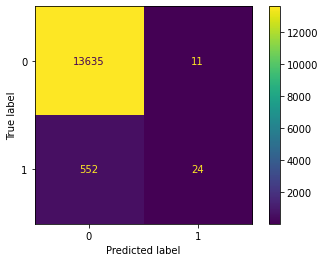

In [520]:
plot_confusion_matrix(logit2,data2[predictors],data2['stroke'])

<h3>4. DISCUSSION</h3>
<p>This confusion matrix tells us how well our model performed. The main diagonal shows us how many the model predicted correctly and the opposite diagonal shows us the number of points the model predicted incorrectly. For example on the yellow square it shows us that when the label was 0 and the model predicted it would be 0, that occured 13568 times.</p>

## PART II

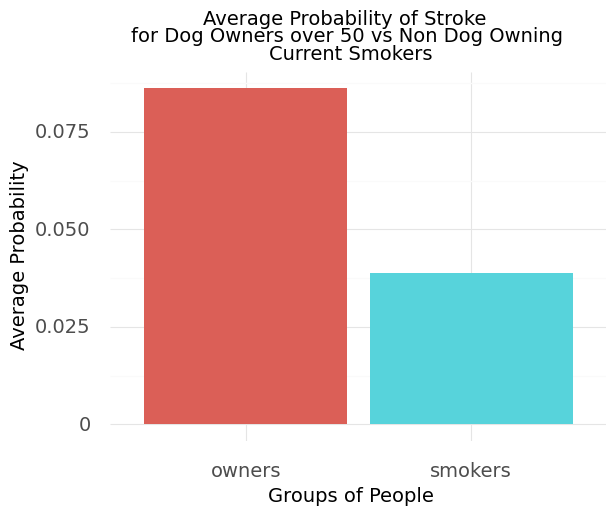

<ggplot: (150250974471)>

In [521]:
# PART II, 1
owners = data.loc[(data['dog_owner']==1) & (data['age']>50)]
owners = owners['stroke'].sum()/len(owners)

smokers = data.loc[(data['smoking_status_smokes']==1) & (data['dog_owner']==0)]
smokers = smokers['stroke'].sum()/len(smokers)

ownvssmoke = pd.DataFrame({'type':['owners','smokers'], 'probability':[owners,smokers]})
(ggplot(ownvssmoke,aes(x='type',y='probability',fill='factor(type)'))
+geom_bar(stat='identity',show_legend=False)
+theme_minimal()
+theme(text=element_text(size=14))
+ylab('Average Probability')
+xlab('Groups of People')
+ggtitle('Average Probability of Stroke  \nfor Dog Owners over 50 vs Non Dog Owning \nCurrent Smokers'))

<h3>1. DISCUSSION</h3>

<p>The Average Probability of a Stroke is higher in the Dog Owning and over 50 group than the Non Dog Owning Smoker Group. The Bar Graph shows that the Average Probability is higher in the red bar than the blue bar.</p>

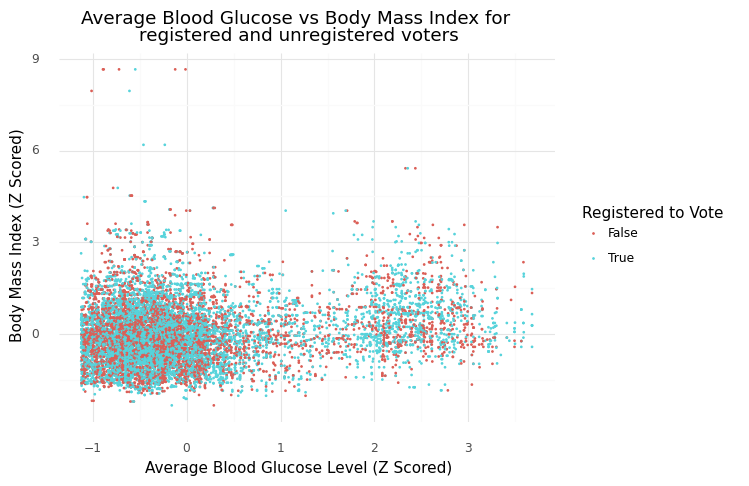

<ggplot: (150247127372)>

In [522]:
# PART II, 2
data2['reg_to_voteTF'] = data['reg_to_vote']==1

(ggplot(data2,aes(x='avg_glucose_level', y='bmi',color='factor(reg_to_voteTF)'))
+geom_point(size=0.1)
+theme_minimal()
+xlab('Average Blood Glucose Level (Z Scored)')
+ylab('Body Mass Index (Z Scored)')
+ggtitle('Average Blood Glucose vs Body Mass Index for \nregistered and unregistered voters')
+labs(color='Registered to Vote'))


<h3>2. DISCUSSION</h3>

<p>I would say that there is a weak very slightly positive relationship between average blood glucose level and body mass index. Between the registered and unregistered voters, the relationship of average blood glucose and bmi seems very similar because many of the points are overlaping in the same areas in similar densities. They even have very similar outliers.</p>

[1.0, 0.9610494995942657, 0.9520785219399538]


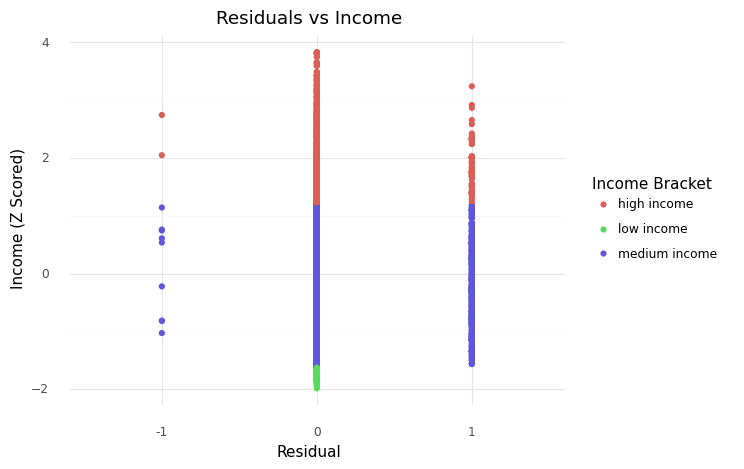

<ggplot: (150232254678)>

In [523]:
# PART II, 3

acc = []

lowincome = data2.loc[data['income_in_k']<30]
lowincome_pred = model.predict(lowincome[predictors])
acc.append(accuracy_score(lowincome['stroke'],lowincome_pred))

data2.loc[data['income_in_k'] < 30, 'incometype'] = 'low income'
data2.loc[data['income_in_k'] > 30, 'incometype'] = 'medium income'

middleincome = data2.loc[(data['income_in_k']>30)&(data['income_in_k']<90)]
middleincome_pred = model.predict(middleincome[predictors])
acc.append(accuracy_score(middleincome['stroke'],middleincome_pred))

highincome = data2.loc[data['income_in_k']>100]
highincome_pred = model.predict(highincome[predictors])
acc.append(accuracy_score(highincome['stroke'],highincome_pred))

data2.loc[data['income_in_k'] > 100, 'incometype'] = 'high income'
data2.loc[(data['income_in_k'] < 100) & (data['income_in_k'] > 30), 'income type'] = 'medium income'

print(acc)
data2['residual'] = data2['stroke']-model.predict(data2[predictors])

(ggplot(data2,aes(x='factor(residual)',y='income_in_k',color='incometype'))
+geom_point()
+theme_minimal()
+ggtitle('Residuals vs Income')
+ylab('Income (Z Scored)')
+xlab('Residual')
+labs(color='Income Bracket'))

<h3>3. DISCUSSION</h3>

<p>In this model the accuracy score is 100% for the low income class, 96.1% for middle income class, and the high income class is 95.2% accurate. Blindly trusting in this accuracy score is very dangerous because it might not represent the real life situations. There are only 237 people in the dataset that are in the lower income class, 11091 people in the middle income class, and 1732 people in the high income class. This makes the dataset skewed because there is more data points for the middle income class. The dataset can represent the fact that lower income and higher income class may be more reluctant or have less time to do surveys or reveal sensitive information. Accuracy in this model does not represent real life and the few data points for a group of people do not generalize for an entire population. The potential accuracy of a model with much more data points of lower/higher income people will make it more representative compared to the current model. It is important to remember that models are not silver bullets to describe the population of the data.</p>

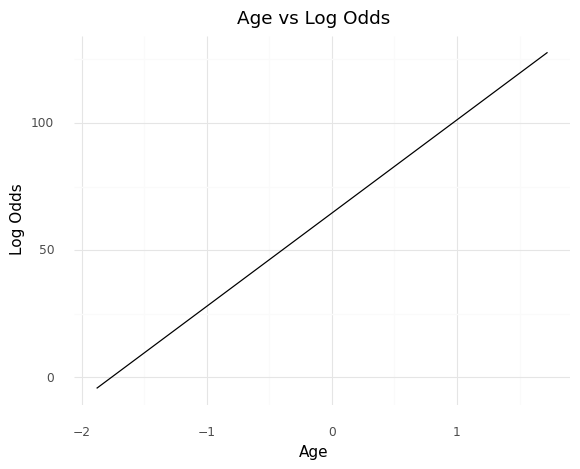

<ggplot: (150236386970)>

In [524]:
# PART II, 4

agedf = pd.DataFrame({'age':data2['age'],'logodds':(logit2.coef_[0][0])*data['age']+logit2.intercept_[0]})
(ggplot(agedf,aes(x='age', y='logodds'))
 +geom_line()
 +theme_minimal()
 +ylab('Log Odds')
 +ggtitle('Age vs Log Odds')
 +xlab('Age'))

<h3>4. DISCUSSION</h3>
<p>The strongest predictor of having a stroke is age. I was able to tell by looking at the coefficents of the logistic regression. The highest coefficent means that per standard deviation, the unit has the biggest imapct on determining if a person had a stroke or not. </p>

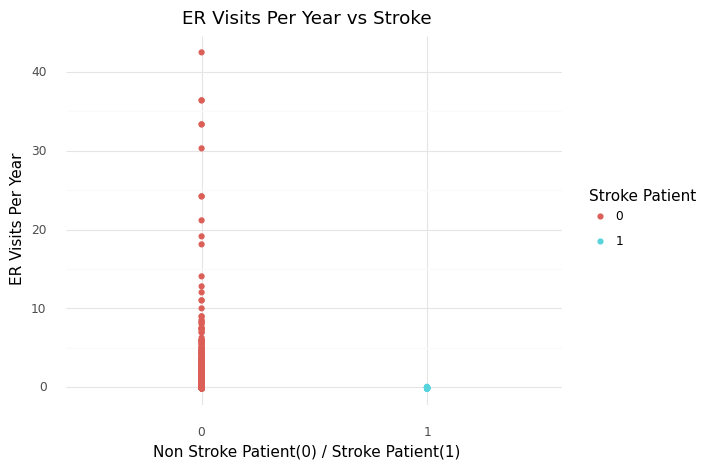

<ggplot: (150232108054)>

In [525]:
# PART II, 5

data2['er_visits_per_year'] = data['er_visits']/data['age']

data2.loc[:,'er_visits_per_year']=zscore.fit_transform(data2[['er_visits_per_year']])
data.loc[data['age']<1]

(ggplot(data2,aes(x='factor(stroke)',y='er_visits_per_year',color='factor(stroke)'))
+geom_point()
+theme_minimal()
+ggtitle('ER Visits Per Year vs Stroke')
+labs(color='Stroke Patient')
+xlab('Non Stroke Patient(0) / Stroke Patient(1)')
+ylab('ER Visits Per Year'))

<h3>5. DISCUSSION</h3>

<p>People with no stroke go to the emergency room much more per year than stroke patients. This can be due to non stroke patients living longer than stroke patients to have the ability to go to the emergency room. The graph above shows that Most of the Stroke Patients ER Visits per year are near zero as the non stroke patients are very spread out.</p>